In [ ]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, ViTModel
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Loading model

In [ ]:
#loading pretrained vit model
model_name = "google/vit-base-patch16-224"

print(f"Loading model {model_name}")
processor = ViTImageProcessor.from_pretrained(model_name)
vit_model = ViTForImageClassification.from_pretrained(model_name)

#test image urls
test_images = {
  "Cat": "http://images.cocodataset.org/val2017/000000039769.jpg",
  "Dog": "http://images.cocodataset.org/val2017/000000000285.jpg",
  "Boat": "http://images.cocodataset.org/val2017/000000000285.jpg"}

#setting model to evaluation mode
vit_model.eval()

#running predictions
for image_name, url in test_images.items():

  #loading image
  image = Image.open(requests.get(url, stream=True).raw)

  #preprocessing image
  inputs = processor(images=image, return_tensors='pt')

  #forward pass
  with torch.no_grad():
    outputs = vit_model(**inputs)

  #getting predictions
  logits = outputs.logits
  predicted_idx = logits.argmax(-1).item()
  predicted_label = vit_model.config.id2label[predicted_idx]

  print(f"{image_name}: {predicted_label}")

print("\nDone")

Loading model google/vit-base-patch16-224
Cat: Egyptian cat
Dog: brown bear, bruin, Ursus arctos
Boat: brown bear, bruin, Ursus arctos

Done


Visualising the path attention

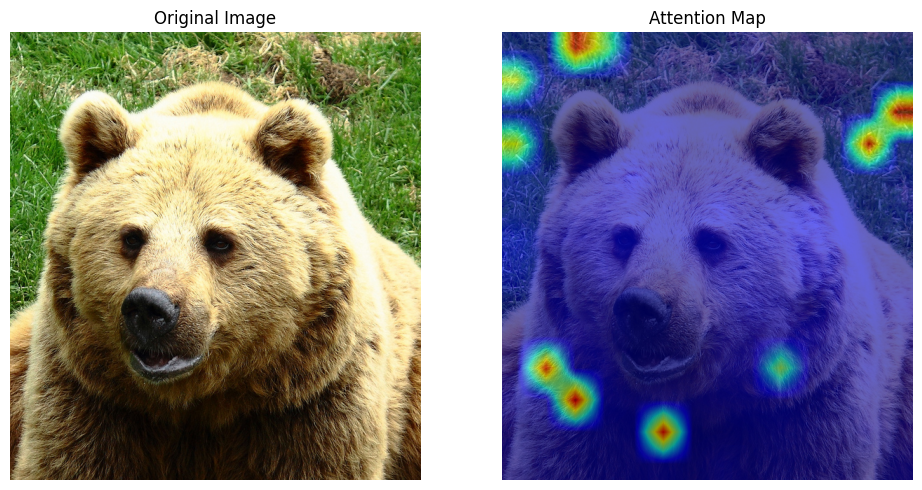

In [ ]:
#loading pretrained vit model
model_name = "google/vit-base-patch16-224"
vit_model = ViTForImageClassification.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

vit_model.set_attn_implementation('eager')

#loading test image
image_url = "http://images.cocodataset.org/val2017/000000000285.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

#preprocessing image
inputs = processor(images=image, return_tensors="pt")

#running model with attention outputs
vit_model.eval()
with torch.no_grad():
  outputs = vit_model(**inputs, output_attentions=True)

#extracting attention from last layer
attention_weights = outputs.attentions[-1]

#averaging attention across all heads
attention_mean = attention_weights.mean(dim=1)

#getting cls token attention to all patches
cls_attention = attention_mean[0, 0, 1:]

#reshaping to 2d grid
grid_size = int(np.sqrt(cls_attention.shape[0]))
attention_map = cls_attention.reshape(grid_size, grid_size)

#upscaling attention map to image size
attention_upscaled = torch.nn.functional.interpolate(
  attention_map.unsqueeze(0).unsqueeze(0),
  size=(image.height, image.width),
  mode='bilinear'
)
attention_upscaled = attention_upscaled.squeeze().detach().numpy()

#plotting original image and attention overlay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

ax2.imshow(image)
ax2.imshow(attention_upscaled, cmap='jet', alpha=0.6)
ax2.set_title("Attention Map")
ax2.axis('off')

plt.tight_layout()
plt.savefig('vit_attention_map.png')
plt.show()

Masking patches

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Original prediction: brown bear, bruin, Ursus arctos (confidence: 99.72%)

Masking experiments:
random masking 25.0%: brown bear, bruin, Ursus arctos (confidence: 99.55%)
random masking 50.0%: brown bear, bruin, Ursus arctos (confidence: 99.65%)
center masking 25.0%: brown bear, bruin, Ursus arctos (confidence: 99.61%)
center masking 50.0%: brown bear, bruin, Ursus arctos (confidence: 99.52%)


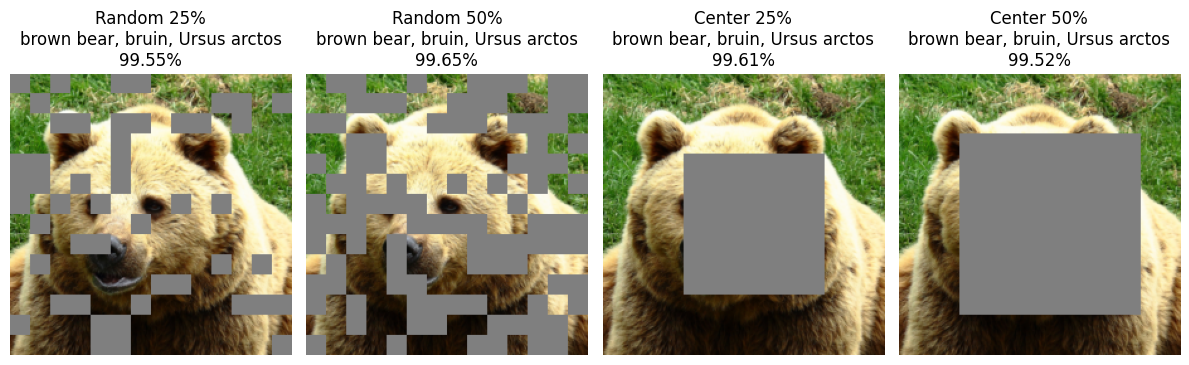


Plot saved as 'vit_masking_robustness.png'


In [ ]:
#loading pretrained vit model
model_name = "google/vit-base-patch16-224"
vit_model = ViTForImageClassification.from_pretrained(model_name).to(device)
processor = ViTImageProcessor.from_pretrained(model_name)
vit_model.eval()

#loading test image
image_url = "http://images.cocodataset.org/val2017/000000000285.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)

#preprocessing image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

#getting original prediction
with torch.no_grad():
  original_outputs = vit_model(pixel_values)
  original_logits = original_outputs.logits
  original_probs = torch.nn.functional.softmax(original_logits, dim=-1)
  original_confidence = original_probs.max().item()
  original_idx = original_logits.argmax().item()
  original_label = vit_model.config.id2label[original_idx]

print(f"Original prediction: {original_label} (confidence: {original_confidence:.2%})")

#function to mask image patches
def mask_patches(image_tensor, mask_mode='random', mask_ratio=0.5):

  masked_image = image_tensor.clone()
  _, _, height, width = masked_image.shape
  patch_size = 16

  #calculating grid dimensions
  grid_height = height // patch_size
  grid_width = width // patch_size
  total_patches = grid_height * grid_width
  num_masked_patches = int(total_patches * mask_ratio)

  if mask_mode == 'random':
    #randomly selecting patches to mask
    patch_indices = np.random.choice(total_patches, num_masked_patches, replace=False)

    for idx in patch_indices:
      row = idx // grid_width
      col = idx % grid_width
      #zeroing out the patch
      masked_image[:, :, row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = 0

  elif mask_mode == 'center':
    #masking center patches
    center_row = grid_height // 2
    center_col = grid_width // 2

    #calculating mask size
    mask_side = int(np.sqrt(num_masked_patches))
    start_row = max(0, center_row - mask_side // 2)
    end_row = min(grid_height, start_row + mask_side)
    start_col = max(0, center_col - mask_side // 2)
    end_col = min(grid_width, start_col + mask_side)

    #applying center mask
    masked_image[:, :, start_row*patch_size:end_row*patch_size, start_col*patch_size:end_col*patch_size] = 0

  return masked_image

#running masking experiments
mask_modes = ['random', 'center']
mask_ratios = [0.25, 0.50]

print("\nMasking experiments:")

plt.figure(figsize=(12, 6))
plot_index = 1

for mode in mask_modes:
  for ratio in mask_ratios:

    #masking image
    masked_input = mask_patches(pixel_values, mask_mode=mode, mask_ratio=ratio)

    #getting prediction on masked image
    with torch.no_grad():
      masked_outputs = vit_model(masked_input)
      masked_logits = masked_outputs.logits
      masked_probs = torch.nn.functional.softmax(masked_logits, dim=-1)
      masked_confidence, masked_idx = masked_probs.max(1)
      masked_label = vit_model.config.id2label[masked_idx.item()]

    print(f"{mode} masking {ratio*100}%: {masked_label} (confidence: {masked_confidence.item():.2%})")

    #preparing image for visualization
    display_image = masked_input.squeeze().permute(1, 2, 0).cpu().numpy()
    display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min())

    #plotting
    ax = plt.subplot(1, 4, plot_index)
    ax.imshow(display_image)
    ax.set_title(f"{mode.capitalize()} {int(ratio*100)}%\n{masked_label}\n{masked_confidence.item():.2%}")
    ax.axis('off')
    plot_index += 1

plt.tight_layout()
plt.savefig('vit_masking_robustness.png')
plt.show()

print("\nPlot saved as 'vit_masking_robustness.png'")

Pooling method comparison

In [ ]:
#loading vit model without classification head
model_name = "google/vit-base-patch16-224"
vit_model = ViTModel.from_pretrained(model_name).to(device)
vit_model.eval()
processor = ViTImageProcessor.from_pretrained(model_name)

#preparing data transformation
transformed = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

#loading training data with subset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformed)
train_subset = torch.utils.data.Subset(train_dataset, list(range(500)))
train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)

#extracting features
print("Extracting features...")

cls_features = []
mean_features = []
labels_list = []

with torch.no_grad():
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    outputs = vit_model(inputs)

    #cls token features
    cls_token = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    cls_features.append(cls_token)

    #mean patch features
    patch_tokens = outputs.last_hidden_state[:, 1:, :]
    mean_token = patch_tokens.mean(dim=1).cpu().numpy()
    mean_features.append(mean_token)

    labels_list.append(labels.numpy())

#combining features
X_cls = np.concatenate(cls_features, axis=0)
X_mean = np.concatenate(mean_features, axis=0)
y = np.concatenate(labels_list, axis=0)

print(f"Training linear probes on {len(y)} samples")

#training linear probe on cls token
probe_cls = LogisticRegression(max_iter=1000, C=1.0)
probe_cls.fit(X_cls, y)
accuracy_cls = probe_cls.score(X_cls, y)

#training linear probe on mean pooling
probe_mean = LogisticRegression(max_iter=1000, C=1.0)
probe_mean.fit(X_mean, y)
accuracy_mean = probe_mean.score(X_mean, y)

#printing results
print(f"\nCLS token accuracy: {accuracy_cls:.2%}")
print(f"Mean pooling accuracy: {accuracy_mean:.2%}")

if accuracy_cls > accuracy_mean:
  print("CLS token performs better")
else:
  print("Mean pooling performs better")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting features...
Training linear probes on 500 samples

CLS token accuracy: 100.00%
Mean pooling accuracy: 100.00%
Mean pooling performs better
